# Ensemble Learning and Random Forests

**我們的第一步應該是收集更多數據並執行特徵工程。與提高性能相比，收集更多數據和特徵工程通常在投入的時間方面具有最大的回報，但是當我們用盡所有數據源時，就該繼續進行模型超參數調優了。**

(關於模型的其他分析用隨機森林那邊做一次而已，其他算法只做大概的調參數)

## Setup

In [32]:

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, GridSearchCV
from scipy.stats import randint, uniform, geom, expon, loguniform
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.patches as patches 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier

為了防止一些Sklearn更新的不必要警告:

In [33]:
# import warnings filter
from warnings import simplefilter
import warnings
#ugnore all future warnings
simplefilter(action='ignore', category=FutureWarning)

create the images/ensembles folder (if it doesn't already exist), and define the save_fig() function which is used through this notebook to save the figures in high-res for the book:

In [34]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# VotingClassifier

創建更好分類器的一種非常簡單的方法是聚合每個分類器的預測並預測獲得最多選票的類別。 這種多數投票分類器稱為 hard voting classifier，當預測變量盡可能相互獨立時，集成方法效果最佳。 獲得多樣化分類器的一種方法是使用非常不同的算法來訓練它們。 這增加了他們犯不同類型錯誤的可能性，從而提高了集成的準確性。


在moons dataset上試試看

In [35]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [36]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

當擬合 VotingClassifier 時，它會克隆每個估計器並擬合克隆，原始估計器可通過 estimators 屬性獲得，而擬合克隆可通過 estimators_ 屬性獲得。 如果您更喜歡字典而不是列表，則可以改用 named_estimators_。

In [37]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


當調用VotingClassifier的 predict() 方法時，它會執行硬投票。 例如，投票分類器為測試集的第一個觀察結果預測類別 1，因為三個分類器中有兩個預測此observation為類別1

In [38]:
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

In [39]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

looks at the performance of the voting classifier on the test set

In [40]:
voting_clf.score(X_test, y_test)

0.912

如果所有分類器都能夠估計類別概率（即，如果它們都有 predict_prova() 方法），那麼可以告訴 Scikit-Learn 使用最高類別概率來預測，對所有單個分類器取平均值。 這稱為soft voting。 soft voting通常比hard voting獲得更高的性能，因為它給高度自信的投票更多的權重。 需要做的就是將VotingClassifier的voting參數設置為“soft”，並確保所有分類器都可以估計類別的概率。 默認情況下SVC不會計算類別概率，所以需要將它的probability參數設置為True（這將使SVC類使用交叉驗證來估計類別的概率，減慢training，並且它會添加一個predict_proba（）方法).

In [41]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

達到92%的Accuracy

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 以下的模型使用Titanic資料

我們使用Titanic資料來做模型的預測，是一個二元分類問題(0代表死亡1代表存活)，就不做EDA與其他preprocessing了，直接建模

In [42]:
data = pd.read_csv("train.csv")

假設經過feature selection後我們選了這四個變數

In [43]:
features = data[['Pclass','Sex','Age','Fare']]
target = data['Survived']

使用策略拆分，讓測試集可以代表整體數據集

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in split.split(features, target):
    x_train = features.loc[train_index]
    y_train = target.loc[train_index]
    x_test = features.loc[test_index]
    y_test = target.loc[test_index]

In [45]:
x_train.head()

,Pclass,Sex,Age,Fare
486,1,female,35.0,90.000
238,2,male,19.0,10.500
722,2,male,34.0,13.000
184,3,female,4.0,22.025
56,2,female,21.0,10.500


In [46]:
len(x_train)

668

In [47]:
y_train.head()

486    1
238    0
722    0
184    1
56     1
Name: Survived, dtype: int64

偷看一下訓練與測試集數據的Y類別比例有沒有一致

In [48]:
y_train.value_counts()/len(y_train)

0    0.616766
1    0.383234
Name: Survived, dtype: float64

In [49]:
y_test.value_counts()/len(y_test)

0    0.61435
1    0.38565
Name: Survived, dtype: float64

# Bagging

## Random Forest

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

sklearn.ensemble.RandomForestClassifier : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

我們需要建立一個preprocessing管道將變數gender做1hot encoding，並以中位數彌補Age中的缺失值

In [50]:
num_cols = x_train.select_dtypes(include='number')
cat_cols = x_train.select_dtypes(include='object')

cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder())
])

imputer_pipeline = Pipeline([
    ("imputer", SimpleImputer())
])

preprocessing  = ColumnTransformer(
    transformers=[
        ("imputeage", imputer_pipeline, ["Age"]),
        ("categorical", cat_pipeline, ["Sex"]),
    ],
    remainder= "passthrough"
)
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('imputeage',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['Age']),
                                ('categorical',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 ['Sex'])])

#### 步驟一 start by creating a baseline model，先建立一個使用預設值的RF。

In [51]:
full_pipeline_rf1 = Pipeline(
    [("preprocessing", preprocessing), ("rf1", RandomForestClassifier(random_state=42))]
)

full_pipeline_rf1.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputeage',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex'])])),
                ('rf1', RandomForestClassifier(random_state=42))])

交叉驗證看看初始rf的表現

In [52]:
full_pipeline_rf1_f1 = cross_val_score(full_pipeline_rf1, x_train, y_train, scoring="f1", cv = 3)

In [53]:
full_pipeline_rf1_f1

array([0.75862069, 0.77987421, 0.77380952])

初始隨機森林表現還行，接下來調參數看能不能進步

### 步驟二 Tuning

找到full tree的深度並將其另存為 max_depth_rf1 。這樣做是為了有個大概的max_depth範圍，能夠構建從 1 到 max_depth_rf1 的參數搜索。

In [54]:
random_forest = full_pipeline_rf1.named_steps["rf1"]
max_depth_rf1 = random_forest.estimators_[0].tree_.max_depth
max_depth_rf1

17

查看整個管道中所有可以調整的參數

In [55]:
print(str(full_pipeline_rf1.get_params().keys()))

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'rf1', 'preprocessing__n_jobs', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__verbose_feature_names_out', 'preprocessing__imputeage', 'preprocessing__categorical', 'preprocessing__imputeage__memory', 'preprocessing__imputeage__steps', 'preprocessing__imputeage__verbose', 'preprocessing__imputeage__imputer', 'preprocessing__imputeage__imputer__add_indicator', 'preprocessing__imputeage__imputer__copy', 'preprocessing__imputeage__imputer__fill_value', 'preprocessing__imputeage__imputer__keep_empty_features', 'preprocessing__imputeage__imputer__missing_values', 'preprocessing__imputeage__imputer__strategy', 'preprocessing__imputeage__imputer__verbose', 'preprocessing__categorical__memory', 'preprocessing__categorical__steps', 'preprocessing__categorical__verbose', 'preprocessing__categorical__onehot', 'prep

使用HalvingRandomSearchCV(基於successive halving的function)進行參數搜索

In [56]:
n_estimators = [int(n_estimators ) for n_estimators  in np.linspace(start=200, stop=2000, num=10)]
max_features = ['sqrt', 3, 'log2']
max_depth = [int(max_depth) for max_depth in range(1, max_depth_rf1 + 1)]
min_samples_split = randint(low = 2, high = 10)
min_samples_leaf = randint(low = 1, high = 5)
bootstrap = [True, False]
strategy = ["median", "mean"]

random_distrib = {
    "preprocessing__imputeage__imputer__strategy" : strategy,
    "rf1__n_estimators" : n_estimators,
    "rf1__max_features" : max_features,
    "rf1__max_depth" : max_depth,
    "rf1__min_samples_split" : min_samples_split,
    "rf1__min_samples_leaf" : min_samples_leaf,
    "rf1__bootstrap" : bootstrap
}
print(random_distrib)

{'preprocessing__imputeage__imputer__strategy': ['median', 'mean'], 'rf1__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'rf1__max_features': ['sqrt', 3, 'log2'], 'rf1__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'rf1__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002464BF66990>, 'rf1__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002464BF39250>, 'rf1__bootstrap': [True, False]}


In [57]:
# Suppress the warning
warnings.filterwarnings("ignore", category=UserWarning)

full_pipeline_rf2 = HalvingRandomSearchCV(full_pipeline_rf1, random_distrib, scoring="f1", cv=3, random_state=42)
full_pipeline_rf2.fit(x_train, y_train)

HalvingRandomSearchCV(cv=3,
                      estimator=Pipeline(steps=[('preprocessing',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('imputeage',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer())]),
                                                                                  ['Age']),
                                                                                 ('categorical',
                                                                                  Pipeline(steps=[('onehot',
                                                                                                   OneHotEncoder())]),
                                                                                  ['Sex'])])),
                                                ('rf1',
                                                 RandomForestClassifier(random_state=42))]),
                      param_distributions={'preprocessin...
                                                              16, 17],
                                           'rf1__max_features': ['sqrt', 3,
                                                                 'log2'],
                                           'rf1__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002464BF39250>,
                                           'rf1__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002464BF66990>,
                                           'rf1__n_estimators': [200, 400, 600,
                                                                 800, 1000,
                                                                 1200, 1400,
                                                                 1600, 1800,
                                                                 2000]},
                      random_state=42, scoring='f1')

In [58]:
pd.DataFrame(full_pipeline_rf2.best_params_, index=[0])\
.assign(f1=full_pipeline_rf2.best_score_)

,preprocessing__imputeage__imputer__strategy,rf1__bootstrap,rf1__max_depth,rf1__max_features,rf1__min_samples_leaf,rf1__min_samples_split,rf1__n_estimators,f1
0,mean,True,9,3,1,2,600,0.762328


In [59]:
cv_res = pd.DataFrame(full_pipeline_rf2.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__imputeage__imputer__strategy",
                 "param_rf1__n_estimators", "param_rf1__max_features", "param_rf1__max_depth", "param_rf1__min_samples_split",
                 "param_rf1__min_samples_leaf","param_rf1__bootstrap", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0_cv", "split1_cv", "split2_cv", "mean_test_f1"]
cv_res.columns = ["strategy", "n_estimators", "max_features", "max_depth", "min_samples_split", "min_samples_leaf", "bootstrap"] + score_cols
cv_res[score_cols] = cv_res[score_cols]
cv_res.head()

,strategy,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap,split0_cv,split1_cv,split2_cv,mean_test_f1
83,mean,600,3,9,2,1,True,0.722892,0.759494,0.804598,0.762328
82,mean,1200,sqrt,16,5,1,True,0.700000,0.759494,0.795455,0.751649
79,mean,600,3,9,2,1,True,0.647059,0.750000,0.810811,0.735957
80,mean,1200,sqrt,16,5,1,True,0.606061,0.769231,0.823529,0.732940
81,mean,200,sqrt,2,2,2,False,0.666667,0.750000,0.774194,0.730287


如果想看特別一個參數對模型表現的影響，如max_depth

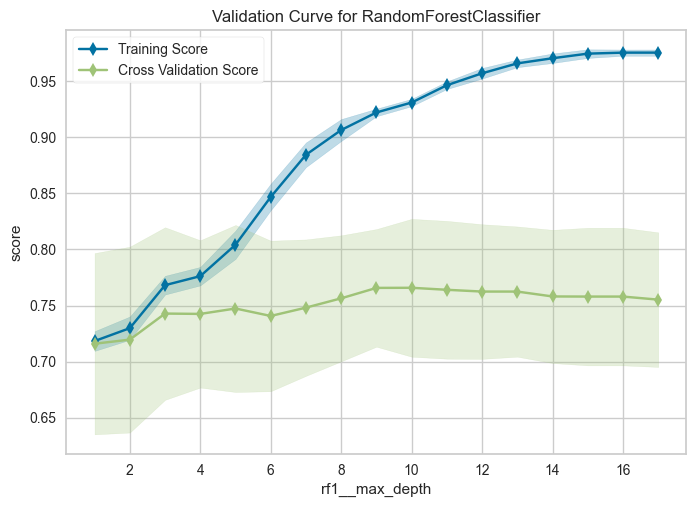

In [60]:
from yellowbrick.model_selection import validation_curve

viz = validation_curve(
    full_pipeline_rf2.best_estimator_, x_train, y_train, param_name="rf1__max_depth",
    param_range=max_depth, cv=10, scoring="f1",
)

的確在max_depth = 9是最佳

### Learning Curve

使用交叉驗證來估計模型的泛化性能。 如果一個模型在訓練數據上表現良好，但根據交叉驗證指標泛化不佳，那麼模型就過度擬合了。 如果它在這兩個方面都表現不佳，那麼它就是欠擬合的。 這是判斷模型何時太簡單或太複雜的一種方法。

另一種方法是查看Learning Curve

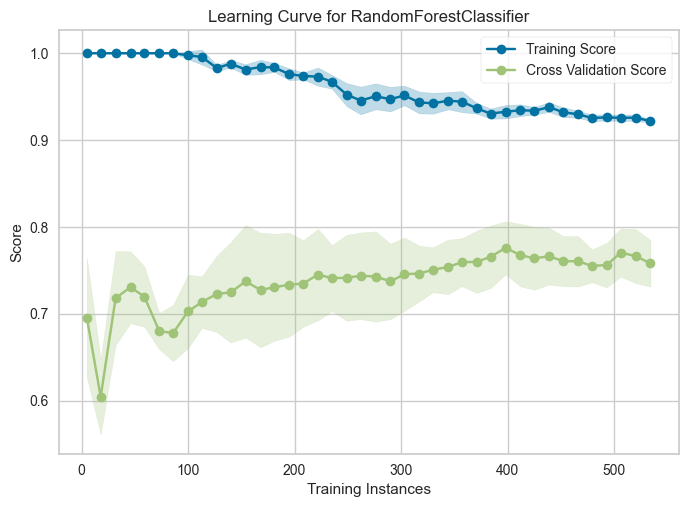

<Axes: title={'center': 'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [61]:

from yellowbrick.model_selection import LearningCurve

#Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.01, 1.0, 40) # generate an array of 40 numbers evenly spaced between 0.01 and 1.0 

Learning_curve = LearningCurve(
    full_pipeline_rf2.best_estimator_, cv=cv, scoring='f1', train_sizes=sizes, 
)

Learning_curve.fit(x_train, y_train)        # Fit the data to the visualizer
Learning_curve.show()           # Finalize and render the figure

 當模型在非常少的訓練observation上進行訓練時，它無法正確泛化，這就是驗證的f1分數最初較小的原因。 然後，隨著模型使用更多的訓練observation，它會學習，因此驗證分數會慢慢上升。 曲線之間有間隙。 這意味著該模型在訓練數據上的表現明顯優於在驗證數據上的表現，這是過度擬合模型的標誌。 但是，如果使用更大的訓練集，兩條曲線會繼續靠近。

### 預測

In [62]:
rf2_predict = cross_val_predict(full_pipeline_rf2.best_estimator_, x_train, y_train, cv=3)

### Confusion matrix

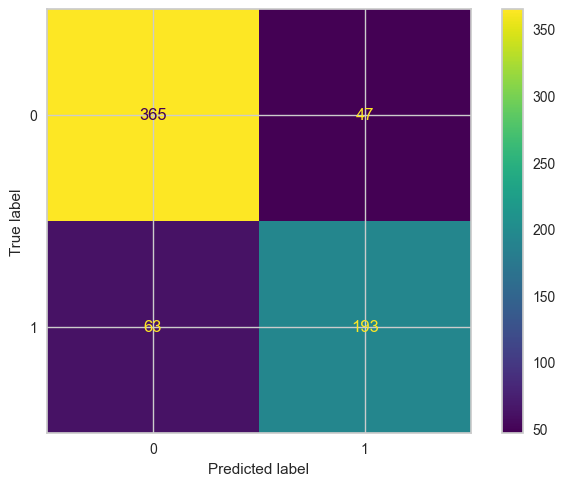

In [63]:
ConfusionMatrixDisplay.from_predictions(y_train, rf2_predict)
plt.show()

In [64]:
f1_rf = f1_score(y_train, rf2_predict)
f1_rf

0.778225806451613

### Precision/Recall Curve and Threshold Plot

可以先畫圖然後看要怎麼決定threshold

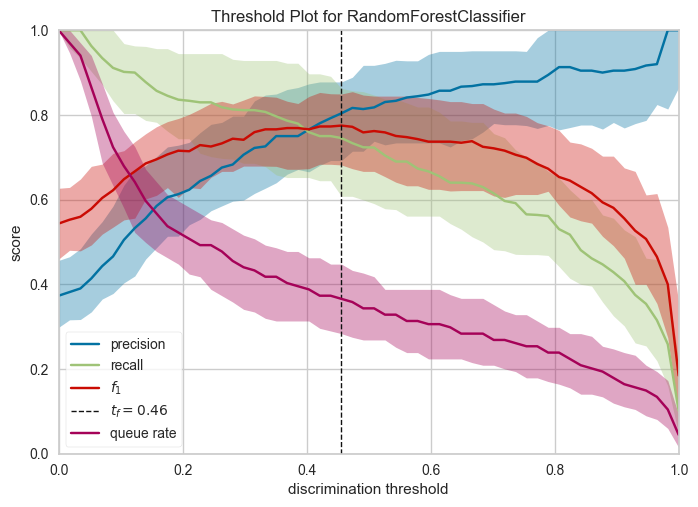

<Axes: title={'center': 'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [65]:
from yellowbrick.classifier import DiscriminationThreshold

discrimination_threshold = DiscriminationThreshold(full_pipeline_rf2.best_estimator_)

discrimination_threshold.fit(x_train, y_train)        # Fit the data to the visualizer
discrimination_threshold.show()           # Finalize and render the figure

(tf虛線代表最高F1 score的threshold)

使用 cross_val_predict() 函數獲取訓練集中所有實例的分數，但這次指定它返回決策分數而不是預測

In [66]:
y_probas_rf2 = cross_val_predict(full_pipeline_rf2.best_estimator_, x_train, y_train, cv=3,
                             method="predict_proba")

In [67]:
y_scores_rf2 = y_probas_rf2[:, 1]#第二欄為陽性的機率
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train, y_scores_rf2 )

也可以這樣手動畫

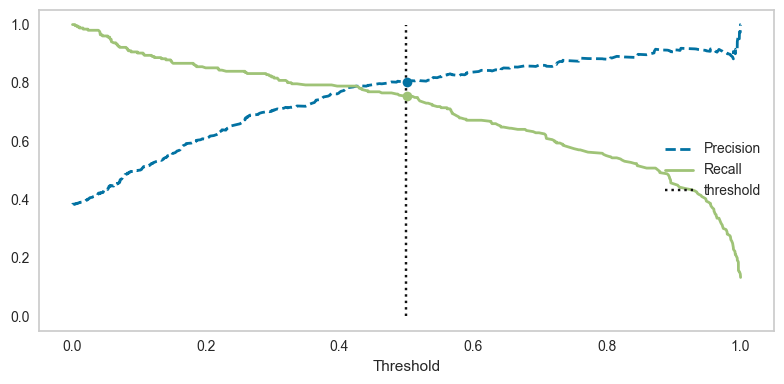

In [68]:
threshold = 0.5#自由更改

plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds_forest, precisions_forest[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds_forest, recalls_forest[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds_forest >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds_forest[idx], precisions_forest[idx], "bo")
plt.plot(thresholds_forest[idx], recalls_forest[idx], "go")
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

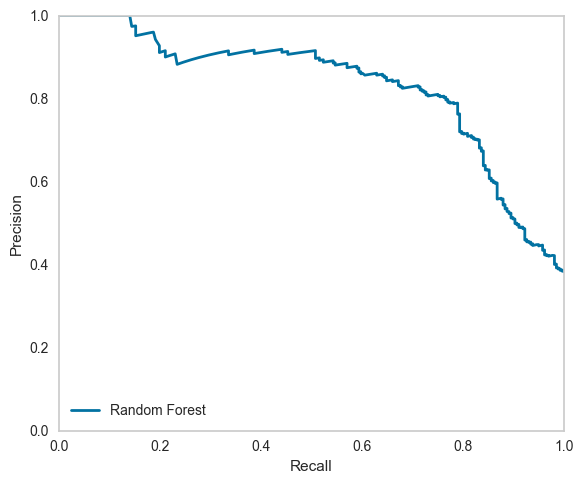

In [69]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

假設目標為precision達到0.9(希望預測是存活的人真的存活)

In [70]:
idx_for_90_precision = (precisions_forest >= 0.90).argmax()
threshold_for_90_precision = thresholds_forest[idx_for_90_precision]
threshold_for_90_precision

0.8705683796175957

In [71]:
y_train_pred_90_precision = (y_scores_rf2 >= threshold_for_90_precision)

In [72]:
precision_score(y_train, y_train_pred_90_precision)

0.9027777777777778

In [73]:
recall_score(y_train, y_train_pred_90_precision)

0.5078125

In [74]:
f1_score(y_train, y_train_pred_90_precision)

0.65

### ROC Curve

In [75]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores_rf2)

作ROC圖並將上面90% Precision的點飆出來

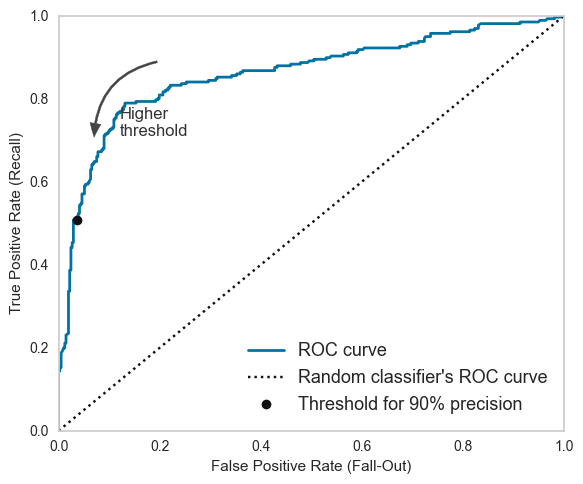

In [76]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

### AUC Score

In [77]:
roc_auc_score(y_train, y_scores_rf2)

0.8605838516383495

### Feature Importance

In [47]:
for score, name in zip(full_pipeline_rf2.best_estimator_.named_steps["rf1"].feature_importances_, x_train.columns) :
    print(round(score,2), name)

0.25 Pclass
0.18 Sex
0.19 Age
0.1 Fare


## ExtraTreesClassifier

當你在隨機森林中種植一棵樹時，在每個節點上，只有特徵的隨機子集被考慮用於分裂。 通過對每個特徵使用隨機閾值而不是搜索最佳閾值，可以使樹更加隨機。 這種極端隨機樹的森林簡稱為Extremely Randomized Trees ensemble（或簡稱為 Extra-Trees）。 這用更多的bias換取了更低的variance。 它還使 Extra-Trees 的訓練速度比常規隨機森林快得多，因為在每個節點為每個特徵找到最佳閾值是常規隨機森林最耗時的任務之一。 可以使用 Scikit-Learn 的 ExtraTreesClassifier 創建一個 Extra-Trees 分類器。 很難提前判斷 RandomForestClassifier 的性能是否優於 ExtraTreesClassifier。 通常，唯一知道的方法是嘗試兩者並使用交叉驗證（並使用網格搜索調整超參數）來比較它們。

先train一個Initial ExtraTreesClassifier

In [109]:
full_pipeline_extra1 = Pipeline(
    [("preprocessing", preprocessing), ("extra1", ExtraTreesClassifier(random_state=42))]
)

full_pipeline_extra1.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputeage',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex'])])),
                ('extra1', ExtraTreesClassifier(random_state=42))])

In [49]:
full_pipeline_extra1_f1 = cross_val_score(full_pipeline_extra1, x_train, y_train, scoring="f1", cv = 3)
full_pipeline_extra1_f1

array([0.72625698, 0.74358974, 0.75903614])

就初始模型相比，ExtraTreesClassifier看起來不會比rfclassifier好，但還是想tune看看(步驟都跟上面一樣)

In [111]:
extra_tree = full_pipeline_extra1.named_steps["extra1"]
max_depth_extra1 = extra_tree.estimators_[0].tree_.max_depth
max_depth_extra1

22

In [112]:
n_estimators = [int(n_estimators ) for n_estimators  in np.linspace(start=200, stop=2000, num=10)]
max_features = ['sqrt', 3, 'log2']
max_depth = [int(max_depth) for max_depth in range(1, max_depth_extra1 + 1)]
min_samples_split = randint(low = 2, high = 10)
min_samples_leaf = randint(low = 1, high = 5)
bootstrap = [True, False]
strategy = ["median", "mean"]

random_distrib_extra = {
    "preprocessing__imputeage__imputer__strategy" : strategy,
    "extra1__n_estimators" : n_estimators,
    "extra1__max_features" : max_features,
    "extra1__max_depth" : max_depth,
    "extra1__min_samples_split" : min_samples_split,
    "extra1__min_samples_leaf" : min_samples_leaf,
    "extra1__bootstrap" : bootstrap
}
print(random_distrib_extra)

{'preprocessing__imputeage__imputer__strategy': ['median', 'mean'], 'extra1__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'extra1__max_features': ['sqrt', 3, 'log2'], 'extra1__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'extra1__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024653125B90>, 'extra1__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002465F07FE50>, 'extra1__bootstrap': [True, False]}


In [113]:
# Suppress the warning
warnings.filterwarnings("ignore", category=UserWarning)

full_pipeline_extra2 = HalvingRandomSearchCV(full_pipeline_extra1, random_distrib_extra, scoring="f1", cv=3, random_state=42)
full_pipeline_extra2.fit(x_train, y_train)

HalvingRandomSearchCV(cv=3,
                      estimator=Pipeline(steps=[('preprocessing',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('imputeage',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer())]),
                                                                                  ['Age']),
                                                                                 ('categorical',
                                                                                  Pipeline(steps=[('onehot',
                                                                                                   OneHotEncoder())]),
                                                                                  ['Sex'])])),
                                                ('extra1',
                                                 ExtraTreesClassifier(random_state=42))]),
                      param_distributions={'extra1__boo...
                                           'extra1__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002465F07FE50>,
                                           'extra1__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024653125B90>,
                                           'extra1__n_estimators': [200, 400,
                                                                    600, 800,
                                                                    1000, 1200,
                                                                    1400, 1600,
                                                                    1800,
                                                                    2000],
                                           'preprocessing__imputeage__imputer__strategy': ['median',
                                                                                           'mean']},
                      random_state=42, scoring='f1')

In [114]:
cv_res = pd.DataFrame(full_pipeline_extra2.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__imputeage__imputer__strategy",
                 "param_extra1__n_estimators", "param_extra1__max_features", "param_extra1__max_depth", "param_extra1__min_samples_split",
                 "param_extra1__min_samples_leaf","param_extra1__bootstrap", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0_cv", "split1_cv", "split2_cv", "mean_test_f1"]
cv_res.columns = ["strategy", "n_estimators", "max_features", "max_depth", "min_samples_split", "min_samples_leaf", "bootstrap"] + score_cols
cv_res[score_cols] = cv_res[score_cols]
cv_res.head()

,strategy,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap,split0_cv,split1_cv,split2_cv,mean_test_f1
82,median,400,sqrt,5,4,1,False,0.716049,0.779221,0.795455,0.763575
83,mean,1200,sqrt,16,5,1,True,0.683544,0.750000,0.818182,0.750575
80,mean,1200,sqrt,16,5,1,True,0.625000,0.785714,0.823529,0.744748
78,median,400,sqrt,5,4,1,False,0.625000,0.740741,0.823529,0.729757
81,median,1200,3,18,3,2,True,0.602740,0.779221,0.795455,0.725805


In [115]:
extra2_predict = cross_val_predict(full_pipeline_extra2.best_estimator_, x_train, y_train, cv=3)

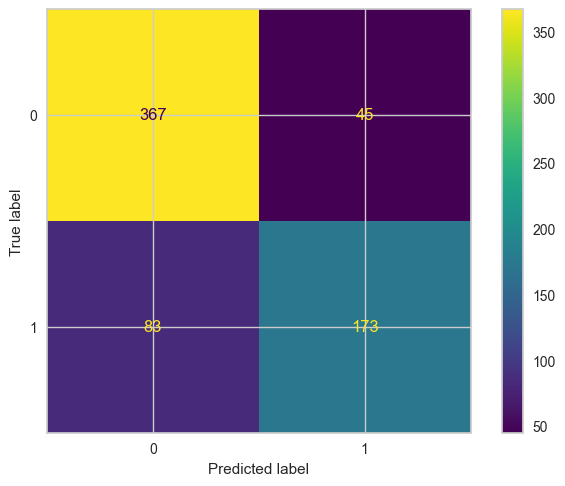

In [116]:
ConfusionMatrixDisplay.from_predictions(y_train, extra2_predict)
plt.show()

In [117]:
f1_extratree = f1_score(y_train, extra2_predict)
f1_extratree

0.729957805907173

看起來與rf classifier相比，extra tree主要是輸在false negative

# Boosting

## AdaBoost

先建立一個使用預設值的AdaBoost(base_estimator會使用DecisionTreeClassifier(max_depth=1))

In [20]:
full_pipeline_ada1 = Pipeline(
    [("preprocessing", preprocessing), ("ada1", AdaBoostClassifier(random_state=42, algorithm = "SAMME.R"))]
)

full_pipeline_ada1.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputeage',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex'])])),
                ('ada1', AdaBoostClassifier(random_state=42))])

交叉驗證看看初始adaboost的表現

In [21]:
full_pipeline_ada1_f1 = cross_val_score(full_pipeline_ada1, x_train, y_train, scoring="f1", cv = 3)
full_pipeline_ada1_f1

array([0.73743017, 0.77987421, 0.77192982])

感覺跟rf差不多，調參數看看

In [22]:
n_estimators = [int(n_estimators ) for n_estimators  in np.linspace(start=200, stop=2000, num=10)]
max_depth = randint(low = 1, high = 20)
learning_rate = loguniform(0.0001, 1)
strategy = ["median", "mean"]

random_distrib_ada = {
    "preprocessing__imputeage__imputer__strategy" : strategy,
    "ada1__n_estimators" : n_estimators,
    "ada1__learning_rate" : learning_rate
}
print(random_distrib_ada)

{'preprocessing__imputeage__imputer__strategy': ['median', 'mean'], 'ada1__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'ada1__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002464BF10990>}


In [23]:
# Suppress the warning
warnings.filterwarnings("ignore", category=UserWarning)

full_pipeline_ada2 = HalvingRandomSearchCV(full_pipeline_ada1, random_distrib_ada, scoring="f1", cv=3, random_state=42)
full_pipeline_ada2.fit(x_train, y_train)

HalvingRandomSearchCV(cv=3,
                      estimator=Pipeline(steps=[('preprocessing',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('imputeage',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer())]),
                                                                                  ['Age']),
                                                                                 ('categorical',
                                                                                  Pipeline(steps=[('onehot',
                                                                                                   OneHotEncoder())]),
                                                                                  ['Sex'])])),
                                                ('ada1',
                                                 AdaBoostClassifier(random_state=42))]),
                      param_distributions={'ada1__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002464BF10990>,
                                           'ada1__n_estimators': [200, 400, 600,
                                                                  800, 1000,
                                                                  1200, 1400,
                                                                  1600, 1800,
                                                                  2000],
                                           'preprocessing__imputeage__imputer__strategy': ['median',
                                                                                           'mean']},
                      random_state=42, scoring='f1')

In [123]:
cv_res = pd.DataFrame(full_pipeline_ada2.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__imputeage__imputer__strategy",
                 "param_ada1__n_estimators", "param_ada1__learning_rate", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0_cv", "split1_cv", "split2_cv", "mean_test_f1"]
cv_res.columns = ["strategy", "n_estimators", "learning_rate"] + score_cols
cv_res[score_cols] = cv_res[score_cols]
cv_res.head()

,strategy,n_estimators,learning_rate,split0_cv,split1_cv,split2_cv,mean_test_f1
83,mean,600,0.000203,0.641026,0.74359,0.747253,0.710623
82,mean,1400,0.000198,0.641026,0.74359,0.747253,0.710623
81,mean,1400,0.00018,0.641026,0.74359,0.747253,0.710623
79,mean,600,0.000203,0.518519,0.60000,0.764706,0.627741
76,mean,1400,0.00018,0.518519,0.60000,0.764706,0.627741


In [124]:
ada2_predict = cross_val_predict(full_pipeline_ada2.best_estimator_, x_train, y_train, cv=3)

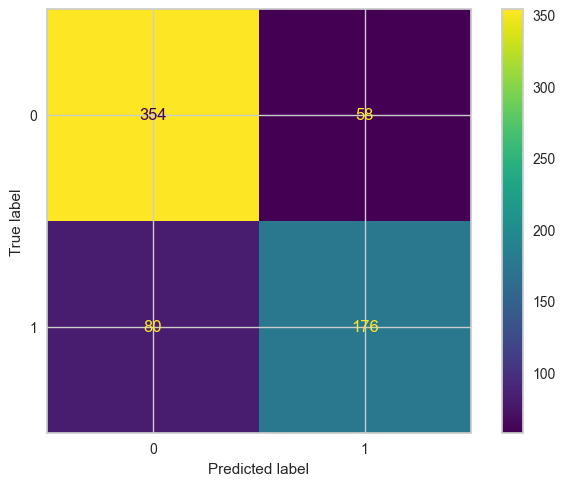

In [125]:
ConfusionMatrixDisplay.from_predictions(y_train, ada2_predict)
plt.show()

In [126]:
f1_adaboost = f1_score(y_train, ada2_predict)
f1_adaboost

0.7183673469387755

## Gradient Boost

## GradientBoostingClassifier or Regressor

tuning步驟:
1. Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems

2. Determine the optimum number of trees for this learning rate. This should range around 40-70. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.

3. Tune tree-specific parameters for decided learning rate and number of trees.

4. Lower the learning rate and increase the estimators proportionally to get more robust models.

#### 步驟一 start by creating a baseline model，先建立一個使用預設值的GBM。

In [61]:
full_pipeline_gbc1 = Pipeline(
    [("preprocessing", preprocessing), ("gbc1", GradientBoostingClassifier(random_state=42))]
)

full_pipeline_gbc1.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputeage',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex'])])),
                ('gbc1', GradientBoostingClassifier(random_state=42))])

In [62]:
full_pipeline_gbc1_f1 = cross_val_score(full_pipeline_gbc1, x_train, y_train, scoring="f1", cv = 3)
full_pipeline_gbc1_f1

array([0.73372781, 0.72483221, 0.77419355])

初始模型比ada boost差

#### 步驟二 使用稍高的learning_rate與粗略估計的其他參數來搜索初始較小範圍的n_estimators

有兩種類型的參數需要調整——tree based and boosting parameters。 learning rate沒有最佳值，更低的值總是效果更好，因為我們在足夠數量的樹上進行訓練。

雖然 GBM 足夠穩健，不會隨著樹的增加而過度擬合，但學習率的太高會導致過度擬合。 然而，隨著我們降低學習率並增加樹，計算變得昂貴並且需要很長時間才能在標準個人計算機上運行，所以才需此步驟。

為了決定初始best _estimators，我們需要設置一些其他參數的初始值。 讓我們採用以下值：

1. min_samples_split = 5 : This should be about 0.5-1% of total training observations. Since this is imbalanced class problem, we’ll take a small value from the range.

2. min_samples_leaf = 3 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.

3. max_depth = 5 : Should be chosen (5-8) based on the number of observations and features. This has 650 rows and 4 columns so lets take 5 here.

4. max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.

5. subsample = 0.8 : This is a commonly used used start value

以上所有參數只是初步估計，後面會進行調整。 讓我們在這裡採用默認學習率 0.1 並找出初始最佳樹的數量。 為此，我們可以進行網格搜索並以 10 為步長測試從 20 到 80 的值:

In [88]:
full_pipeline_gbc2 = Pipeline(
    [("preprocessing", preprocessing), ("gbc2", GradientBoostingClassifier(random_state=42, learning_rate=0.1, min_samples_split = 5, min_samples_leaf=3, max_depth=5, max_features='sqrt', subsample=0.8))]
)
param_grid1 = {"gbc2__n_estimators":range(20,81,10)}


gsearch1 = GridSearchCV(full_pipeline_gbc2, param_grid1, scoring='f1', cv=3,)

In [89]:
gsearch1.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputeage',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex'])])),
                                       ('gbc2',
                                        GradientBoostingClassifier(max_depth=5,
                                                                   max_features='sqrt',
                                                                   min_samples_leaf=3,
                                                                   min_samples_split=5,
                                                                   random_state=42,
                                                                   subsample=0.8))]),
             param_grid={'gbc2__n_estimators': range(20, 81, 10)},
             scoring='f1')

In [90]:
gsearch1.best_params_, gsearch1.best_score_


({'gbc2__n_estimators': 70}, 0.7797405247353447)

這裡我們得到 70 作為 0.1 學習率的最佳估計量。 請注意，70 是一個合理的值，後面可以直接使用，但它可能並非在所有情況下都相同。 其他情況：

1. 如果該值在 20 左右，可以嘗試將學習率降低到 0.05 並重新運行網格搜索

2. 如果值太高~100，調整其他參數會花費很長時間，可以嘗試更高的學習率

#### 步驟三 調整特定於樹的參數

Now lets move onto tuning the tree parameters. I plan to do this in following stages:

1. Tune max_depth and num_samples_split

2. Tune min_samples_leaf

3. Tune max_features

**應仔細決定調整變量的順序。 您應該首先考慮對結果影響較大的變量。** 例如，max_depth 和 min_samples_split 有重大影響，我們首先調整它們。

首先，以 1 的步長測試 5 到 15 的 max_depth 值、以 1 的步長測試 2 到 10 的 min_samples_split 值、以 1 的步長測試 1 到 5 的 min_samples_leaf 值。這些只是基於直覺。 也可以設置更寬的範圍，然後對更小的範圍執行多次迭代。同時，也尋找preprocessing裡的最佳參數(這裡是缺失值的填補方法)

In [84]:
full_pipeline_gbc3 = Pipeline(
    [("preprocessing", preprocessing), ("gbc3", GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=70, max_features='sqrt', subsample=0.8))]
)
param_grid2 = {"preprocessing__imputeage__imputer__strategy" : ["median", "mean"],
               'gbc3__max_depth':range(5,15,1), 
               'gbc3__min_samples_split':range(2,10,1),
               'gbc3__min_samples_leaf':range(1,5,1)}
gsearch2 = GridSearchCV(full_pipeline_gbc3, param_grid2, scoring='f1', cv=3)

In [85]:
gsearch2.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputeage',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex'])])),
                                       ('gbc3',
                                        GradientBoostingClassifier(max_features='sqrt',
                                                                   n_estimators=70,
                                                                   random_state=42,
                                                                   subsample=0.8))]),
             param_grid={'gbc3__max_depth': range(5, 15),
                         'gbc3__min_samples_leaf': range(1, 5),
                         'gbc3__min_samples_split': range(2, 10),
                         'preprocessing__imputeage__imputer__strategy': ['median',
                                                                         'mean']},
             scoring='f1')

In [86]:
gsearch2.best_params_, gsearch2.best_score_

({'gbc3__max_depth': 5,
  'gbc3__min_samples_leaf': 4,
  'gbc3__min_samples_split': 9,
  'preprocessing__imputeage__imputer__strategy': 'median'},
 0.7855285677706852)

In [87]:
cv_res = pd.DataFrame(gsearch2.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__imputeage__imputer__strategy",
                "param_gbc3__max_depth", "param_gbc3__min_samples_split",
                 "param_gbc3__min_samples_leaf", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0_cv", "split1_cv", "split2_cv", "mean_test_f1"]
cv_res.columns = ["strategy","max_depth", "min_samples_split", "min_samples_leaf"] + score_cols
cv_res[score_cols] = cv_res[score_cols]
cv_res.head()

,strategy,max_depth,min_samples_split,min_samples_leaf,split0_cv,split1_cv,split2_cv,mean_test_f1
62,median,5,9,4,0.779070,0.787097,0.790419,0.785529
42,median,5,7,3,0.773810,0.787097,0.792683,0.784530
47,mean,5,9,3,0.761364,0.779221,0.812121,0.784235
116,median,6,4,4,0.771930,0.792208,0.788235,0.784124
124,median,6,8,4,0.771930,0.792208,0.788235,0.784124


max_depth 的理想值為 5，min_samples_split 的理想值為 9, min_samples_leaf的理想值為4。 請注意，max_depth的理想值5是我們測試的下限，最優值有可能低於該值，所以也應該檢查一些更低的值:

In [93]:
full_pipeline_gbc4 = Pipeline(
    [("preprocessing", preprocessing), ("gbc4", GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=70, min_samples_split = 9, min_samples_leaf=4, max_features='sqrt', subsample=0.8))]
)
param_grid3 = {"preprocessing__imputeage__imputer__strategy" : ["median"],
               'gbc4__max_depth':range(1,8,1)}
gsearch3 = GridSearchCV(full_pipeline_gbc4, param_grid3, scoring='f1', cv=3)

In [94]:
gsearch3.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputeage',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex'])])),
                                       ('gbc4',
                                        GradientBoostingClassifier(max_features='sqrt',
                                                                   min_samples_leaf=4,
                                                                   min_samples_split=9,
                                                                   n_estimators=70,
                                                                   random_state=42,
                                                                   subsample=0.8))]),
             param_grid={'gbc4__max_depth': range(1, 8),
                         'preprocessing__imputeage__imputer__strategy': ['median']},
             scoring='f1')

In [95]:
gsearch3.best_params_, gsearch3.best_score_

({'gbc4__max_depth': 5,
  'preprocessing__imputeage__imputer__strategy': 'median'},
 0.7855285677706852)

看起來max_depth 的理想值為5沒錯了

現在調整最後一個樹參數，即 max_features，以1為步長嘗試從1到4的4個值。

In [96]:
full_pipeline_gbc5 = Pipeline(
    [("preprocessing", preprocessing), ("gbc5", GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=70, max_depth=5, min_samples_split=9, min_samples_leaf=4, subsample=0.8))]
)
param_grid4 = {"preprocessing__imputeage__imputer__strategy" : ["median"],
               'gbc5__max_features':range(1,5,1)}
gsearch4 = GridSearchCV(full_pipeline_gbc5, param_grid4, scoring='f1', cv=3)

In [97]:
gsearch4.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputeage',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex'])])),
                                       ('gbc5',
                                        GradientBoostingClassifier(max_depth=5,
                                                                   min_samples_leaf=4,
                                                                   min_samples_split=9,
                                                                   n_estimators=70,
                                                                   random_state=42,
                                                                   subsample=0.8))]),
             param_grid={'gbc5__max_features': range(1, 5),
                         'preprocessing__imputeage__imputer__strategy': ['median']},
             scoring='f1')

In [98]:
gsearch4.best_params_, gsearch4.best_score_

({'gbc5__max_features': 2,
  'preprocessing__imputeage__imputer__strategy': 'median'},
 0.7855285677706852)

max_features 的理想值為2(剛好也是預設值的"sqrt"數量)

we have the final tree-parameters as:

* min_samples_split: 9

* min_samples_leaf: 4

* max_depth: 5

* max_features: 2

#### 步驟四 Tuning subsample and making models with lower learning rate

下一步將嘗試不同的subsample值。 讓我們取值 0.6、0.7、0.75、0.8、0.85、0.9。

In [131]:
full_pipeline_gbc6 = Pipeline(
    [("preprocessing", preprocessing), ("gbc6", GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=70, max_depth=5, min_samples_split=9, min_samples_leaf=4,max_features=2))]
)
param_grid5 = {"preprocessing__imputeage__imputer__strategy" : ["median"],
               'gbc6__subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(full_pipeline_gbc6, param_grid5, scoring='f1', cv=3)

In [132]:
gsearch5.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputeage',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex'])])),
                                       ('gbc6',
                                        GradientBoostingClassifier(max_depth=5,
                                                                   max_features=2,
                                                                   min_samples_leaf=4,
                                                                   min_samples_split=9,
                                                                   n_estimators=70,
                                                                   random_state=42))]),
             param_grid={'gbc6__subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
                         'preprocessing__imputeage__imputer__strategy': ['median']},
             scoring='f1')

In [133]:
gsearch5.best_params_, gsearch5.best_score_

({'gbc6__subsample': 0.8,
  'preprocessing__imputeage__imputer__strategy': 'median'},
 0.7855285677706852)

在這裡，發現 0.85 作為subsample最佳值，目前已經擁有了所有需要的參數。 

現在，我們需要降低learning rate並按比例增加n_estimators的數量。讓我們將學習率降低一半，即 0.05，樹的數量增加兩倍（140）。

In [134]:
gbc_final = gsearch5.best_estimator_.named_steps["gbc6"].set_params(learning_rate=0.05, n_estimators=140)

full_pipeline_final = Pipeline(
    [("preprocessing", preprocessing), ("gbcfinal", gbc_final)]
)

full_pipeline_final

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputeage',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex'])])),
                ('gbcfinal',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=5,
                                            max_features=2, min_samples_leaf=4,
                                            min_samples_split=9,
                                            n_estimators=140, random_state=42,
                                            subsample=0.8))])

In [125]:
cross_val_score(full_pipeline_final, x_train, y_train, scoring='f1', cv=3)

array([0.77456647, 0.80519481, 0.8       ])

現在讓我們減少到原始值的十分之一，即 700 棵樹與0.01的learning_rate。

In [135]:
gbc_final = gsearch5.best_estimator_.named_steps["gbc6"].set_params(learning_rate=0.01, n_estimators=700)

full_pipeline_final = Pipeline(
    [("preprocessing", preprocessing), ("gbcfinal", gbc_final)]
)

cross_val_score(full_pipeline_final, x_train, y_train, scoring='f1', cv=3)

array([0.75862069, 0.80519481, 0.79268293])

讓我們減少到原始值的二十分之一，即 1400 棵樹與0.005的learning_rate。

In [136]:
gbc_final = gsearch5.best_estimator_.named_steps["gbc6"].set_params(learning_rate=0.005, n_estimators=1400)

full_pipeline_final = Pipeline(
    [("preprocessing", preprocessing), ("gbcfinal", gbc_final)]
)

cross_val_score(full_pipeline_final, x_train, y_train, scoring='f1', cv=3)

array([0.75862069, 0.79220779, 0.79754601])

在這裡看到f1分數略有下降。所以用同樣的學習率跑 2000 棵樹看看。

In [137]:
gbc_final = gsearch5.best_estimator_.named_steps["gbc6"].set_params(learning_rate=0.005, n_estimators=2000)

full_pipeline_final = Pipeline(
    [("preprocessing", preprocessing), ("gbcfinal", gbc_final)]
)

cross_val_score(full_pipeline_final, x_train, y_train, scoring='f1', cv=3)

array([0.75862069, 0.78205128, 0.79041916])

看起來learning_rate=0.05, n_estimators=140時表現就夠好了，很難再提升，於是預測看看:

In [138]:
gbc_final = gsearch5.best_estimator_.named_steps["gbc6"].set_params(learning_rate=0.05, n_estimators=140)

full_pipeline_final = Pipeline(
    [("preprocessing", preprocessing), ("gbcfinal", gbc_final)]
)

gbc_predict = cross_val_predict(full_pipeline_final, x_train, y_train, cv=3)

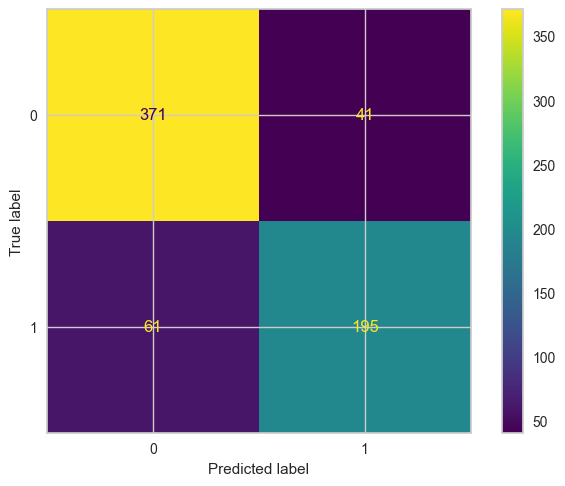

In [139]:
ConfusionMatrixDisplay.from_predictions(y_train, gbc_predict)
plt.show()

In [140]:
f1_gradientboost = f1_score(y_train, gbc_predict)
f1_gradientboost 

0.7926829268292683

從初始的GBM模型到調參完的模型，f1分數由約0.73上升到約0.79，算不錯了

## Histogram-Based Gradient Boosting

除了 GradientBoostingClassifier（或 Regressor），Scikit-Learn 還提供了另一種針對大型數據集優化的boosting 算法，histogram-based gradient boosting（HGB），HistGradientBoostingClassifier（或 Regressor）。 它的工作原理是對輸入特徵進行分箱，用整數代替它們。 bins 的數量由 max_bins 超參數控制，默認為 225，不能設置比225更高。 合併可以大大減少訓練算法需要評估的可能閾值的數量。 此外，使用整數可以使用更快、更節省內存的數據結構。 並且 bins 的構建方式消除了在訓練每棵樹時對特徵進行排序的需要。

此算法的計算複雜度為 O(bxm) ，而不是一般gradient boost的O(nxmxlog(m))，其中 b 是 bin 的數量，m 是訓練觀察的數量，n 是特徵的數量。 實際上，這意味著 HGB 在大型數據集上的訓練速度比常規 GBRT 快數百倍。 然而，bining 會導致precision失，且變成正則化的一種：根據數據集，這可能有助於減少過度擬合，也可能導致欠擬合。

詳細作法跟GBM差不多

## XGBoost

In [133]:
from xgboost import XGBClassifier

--------------------------

python 中的 xgboost 有一個名為 XGBClassifier 參數的 sklearn 包裝器。 它使用 sklearn 風格的命名。 將更改的參數名稱是：

eta –> learning_rate

ambda –> reg_lambda

alpha –> reg_alpha


tuning步驟

1. Choose a relatively high learning rate. Generally, a learning rate of 0.1 works, but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.

2. Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for the decided learning rate and the number of trees. Note that we can choose different parameters to define a tree, and I’ll take up an example here.

3. Tune regularization parameters (lambda, alpha) for xgboost, which can help reduce model complexity and enhance performance.

4. Lower the learning rate and decide the optimal parameters.


--------------------

#### 步驟一 start by creating a baseline model，先建立一個使用預設值的XGB。

In [134]:
full_pipeline_xgb1 = Pipeline(
    [("preprocessing", preprocessing), ("xgb1", XGBClassifier(random_state=42))]
)

full_pipeline_xgb1.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputeage',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex'])])),
                ('xgb1',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [135]:
full_pipeline_xgb1_f1 = cross_val_score(full_pipeline_xgb1, x_train, y_train, scoring="f1", cv = 3)
full_pipeline_xgb1_f1

array([0.75      , 0.77124183, 0.77108434])

#### 步驟二 使用稍高的learning_rate與粗略估計的其他參數來搜索初始較小範圍的n_estimators

為了決定初始best _estimators，我們需要設置一些其他參數的初始值。 讓我們採用以下值：

1. max_depth = 5: This should be between 3-10. I’ve started with 5, but can choose a different number as well. 4-6 can be good starting points.

2. min_child_weight = 1: A smaller value is chosen because it is an imbalanced class problem, and leaf nodes can have smaller size groups.

3. gamma = 0: A smaller value like 0.1-0.2 can also be chosen for starting. This will, anyways, be tuned later.

4. subsample, colsample_bytree = 0.8: This is a commonly used start value. Typical values range between 0.5-0.9.

5. scale_pos_weight = 1: Because of class imbalance.

以上所有參數只是初步估計，後面會進行調整。 讓我們在這裡採用默認學習率 0.1 並找出初始最佳樹的數量。 為此，我們可以進行網格搜索並以 10 為步長測試從 20 到 200的值:

In [136]:
full_pipeline_xgb2 = Pipeline(
    [("preprocessing", preprocessing), ("xgb2", XGBClassifier(learning_rate =0.1,
                                                              max_depth=5, 
                                                              min_child_weight=1, 
                                                              gamma=0,  
                                                              subsample=0.8,
                                                              colsample_bytree=0.8,
                                                              objective= 'binary:logistic',
                                                              scale_pos_weight=1,
                                                              seed=27))]
)

param_grid1 = {"xgb2__n_estimators":range(20,201,10)}
gsearch1 = GridSearchCV(full_pipeline_xgb2, param_grid1, scoring='f1', cv=3,)

In [137]:
gsearch1.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputeage',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex'])])),
                                       ('xgb2',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      cols...
                                                      interaction_constraints=None,
                                                      learning_rate=0.1,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=5,
                                                      max_leaves=None,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'xgb2__n_estimators': range(20, 201, 10)},
             scoring='f1')

In [138]:
gsearch1.best_params_, gsearch1.best_score_

({'xgb2__n_estimators': 90}, 0.7911265118239609)

這裡我們得到 90 作為 0.1 學習率的最佳估計量。 請注意，90 是一個合理的值，後面可以直接使用，但它可能並非在所有情況下都相同。 其他情況：

1. 如果該值在 20 左右，可以嘗試將學習率降低到 0.05 並重新運行網格搜索

2. 如果值太高~100，調整其他參數會花費很長時間，可以嘗試更高的學習率

#### 步驟三 Tune max_depth and min_child_weight

首先調整這兩個，因為它們將對模型結果產生最大的影響。因為這邊資料量很少，參數值可以以間隔為1，如果資料量大，可以設置更寬的範圍且參數值間隔大一些，然後再為更小的範圍執行另一次迭代搜索。

同時，也尋找preprocessing裡的最佳參數(這裡是缺失值的填補方法)

In [144]:
full_pipeline_xgb3 = Pipeline(
    [("preprocessing", preprocessing), ("xgb3", XGBClassifier(learning_rate =0.1, n_estimators=90, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight=1, seed=42))]
)
param_grid2 = {"preprocessing__imputeage__imputer__strategy" : ["median", "mean"],
               'xgb3__max_depth':range(3,15,1), 
               'xgb3__min_child_weight':range(1,6,1)}
gsearch2 = GridSearchCV(full_pipeline_xgb3, param_grid2, scoring='f1', cv=3)

In [145]:
gsearch2.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputeage',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex'])])),
                                       ('xgb3',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      cols...
                                                      max_delta_step=None,
                                                      max_depth=5,
                                                      max_leaves=None,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=90,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'preprocessing__imputeage__imputer__strategy': ['median',
                                                                         'mean'],
                         'xgb3__max_depth': range(3, 15),
                         'xgb3__min_child_weight': range(1, 6)},
             scoring='f1')

In [147]:
gsearch2.best_params_, gsearch2.best_score_

({'preprocessing__imputeage__imputer__strategy': 'median',
  'xgb3__max_depth': 12,
  'xgb3__min_child_weight': 1},
 0.7821661998132585)

In [148]:
cv_res = pd.DataFrame(gsearch2.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__imputeage__imputer__strategy",
                "param_xgb3__max_depth", "param_xgb3__min_child_weight", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0_cv", "split1_cv", "split2_cv", "mean_test_f1"]
cv_res.columns = ["strategy","max_depth", "min_child_weight"] + score_cols
cv_res[score_cols] = cv_res[score_cols]
cv_res.head()

,strategy,max_depth,min_child_weight,split0_cv,split1_cv,split2_cv,mean_test_f1
45,median,12,1,0.776471,0.784314,0.785714,0.782166
40,median,11,1,0.783626,0.776316,0.785714,0.781885
75,mean,6,1,0.767442,0.794872,0.781065,0.781126
55,median,14,1,0.776471,0.776316,0.788235,0.780341
25,median,8,1,0.771930,0.794872,0.773810,0.780204


max_depth 的理想值為 12，min_child_weight 為 1。 

#### 步驟四 Tune gamma

現在讓我們使用上面已經調整過的參數調整伽瑪值。 Gamma 可以取不同的值，但我會在這裡檢查 5 個值。 也可以輸入更精確的值。

In [151]:
full_pipeline_xgb4 = Pipeline(
    [("preprocessing", preprocessing), ("xgb4", XGBClassifier(learning_rate =0.1, n_estimators=90, max_depth=12,
 min_child_weight=1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight=1, seed=42))]
)
param_grid3 = {"preprocessing__imputeage__imputer__strategy" : ["mean"],
               'xgb4__gamma':[i/10.0 for i in range(0,5)]}
gsearch3 = GridSearchCV(full_pipeline_xgb4, param_grid3, scoring='f1', cv=3)

In [152]:
gsearch3.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputeage',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex'])])),
                                       ('xgb4',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      cols...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=12,
                                                      max_leaves=None,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=90,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'preprocessing__imputeage__imputer__strategy': ['mean'],
                         'xgb4__gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='f1')

In [156]:
gsearch3.best_params_, gsearch3.best_score_

({'preprocessing__imputeage__imputer__strategy': 'mean', 'xgb4__gamma': 0.3},
 0.7724112804757967)

gamma的理想值為0.3

在繼續之前，一個好主意是重新校準，使用目前找到的參數更新n_estimators。

In [158]:
full_pipeline_xgb5 = Pipeline(
    [("preprocessing", preprocessing), ("xgb5", XGBClassifier(learning_rate =0.1,
                                                              max_depth=12, 
                                                              min_child_weight=1, 
                                                              gamma=0.3,  
                                                              subsample=0.8,
                                                              colsample_bytree=0.8,
                                                              objective= 'binary:logistic',
                                                              scale_pos_weight=1,
                                                              seed=42))]
)

param_grid4 = {"preprocessing__imputeage__imputer__strategy" : ["mean"],
               "xgb5__n_estimators":range(20,201,10)}
gsearch4 = GridSearchCV(full_pipeline_xgb5, param_grid4, scoring='f1', cv=3,)

In [159]:
gsearch4.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputeage',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex'])])),
                                       ('xgb5',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      cols...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=12,
                                                      max_leaves=None,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'preprocessing__imputeage__imputer__strategy': ['mean'],
                         'xgb5__n_estimators': range(20, 201, 10)},
             scoring='f1')

In [160]:
gsearch4.best_params_, gsearch4.best_score_

({'preprocessing__imputeage__imputer__strategy': 'mean',
  'xgb5__n_estimators': 70},
 0.7774490466798158)

#### 步驟五 Tune subsample and colsample_bytree

下一步是嘗試不同的subsample和 colsample_bytree 值。 讓我們也分兩個階段執行此操作，首先取值 0.6、0.7、0.8、0.9:

In [161]:
full_pipeline_xgb6 = Pipeline(
    [("preprocessing", preprocessing), ("xgb6", XGBClassifier(learning_rate =0.1, n_estimators=70, max_depth=12,
 min_child_weight=1, gamma=0.3,
 objective= 'binary:logistic', scale_pos_weight=1, seed=42))]
)
param_grid5 = {"preprocessing__imputeage__imputer__strategy" : ["mean"],
               'xgb6__subsample':[i/10.0 for i in range(6,10)],
               'xgb6__colsample_bytree':[i/10.0 for i in range(6,10)]}
gsearch5 = GridSearchCV(full_pipeline_xgb6, param_grid5, scoring='f1', cv=3)

In [162]:
gsearch5.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputeage',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex'])])),
                                       ('xgb6',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      cols...
                                                      max_delta_step=None,
                                                      max_depth=12,
                                                      max_leaves=None,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=70,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'preprocessing__imputeage__imputer__strategy': ['mean'],
                         'xgb6__colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'xgb6__subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='f1')

In [163]:
gsearch5.best_params_, gsearch5.best_score_

({'preprocessing__imputeage__imputer__strategy': 'mean',
  'xgb6__colsample_bytree': 0.8,
  'xgb6__subsample': 0.7},
 0.7849196344153798)

colsample_bytree的理想值為0.8, subsample的理想值為0.7

現在圍繞上面的值並以 0.05 的間隔嘗試值。

In [165]:
full_pipeline_xgb7 = Pipeline(
    [("preprocessing", preprocessing), ("xgb7", XGBClassifier(learning_rate =0.1, n_estimators=70, max_depth=12,
 min_child_weight=1, gamma=0.3,
 objective= 'binary:logistic', scale_pos_weight=1, seed=42))]
)
param_grid6 = {"preprocessing__imputeage__imputer__strategy" : ["mean"],
               'xgb7__subsample':[i/100.0 for i in range(60,80,5)],
               'xgb7__colsample_bytree':[i/100.0 for i in range(70,90,5)]}
gsearch6 = GridSearchCV(full_pipeline_xgb7, param_grid6, scoring='f1', cv=3)

In [166]:
gsearch6.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputeage',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex'])])),
                                       ('xgb7',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      cols...
                                                      max_delta_step=None,
                                                      max_depth=12,
                                                      max_leaves=None,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=70,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'preprocessing__imputeage__imputer__strategy': ['mean'],
                         'xgb7__colsample_bytree': [0.7, 0.75, 0.8, 0.85],
                         'xgb7__subsample': [0.6, 0.65, 0.7, 0.75]},
             scoring='f1')

In [167]:
gsearch6.best_params_, gsearch6.best_score_

({'preprocessing__imputeage__imputer__strategy': 'mean',
  'xgb7__colsample_bytree': 0.8,
  'xgb7__subsample': 0.7},
 0.7849196344153798)

再次獲得與之前相同的值。 因此最佳值為：

* colsample_bytree: 0.8

* subsample': 0.7

#### 步驟六 Tuning regularization parameters(reg_alpha)

下一步是應用正則化來減少過度擬合。 然而，許多人並不經常使用這個參數，因為gamma 提供了一種控制複雜性的實質性方法。 但應該還是要嘗試。

In [154]:
full_pipeline_xgb8 = Pipeline(
    [("preprocessing", preprocessing), ("xgb8", XGBClassifier(learning_rate =0.1, n_estimators=70, max_depth=12,
 min_child_weight=1, gamma=0.3, subsample=0.7, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight=1, seed=42))]
)
param_grid7 = {"preprocessing__imputeage__imputer__strategy" : ["mean"],
               'xgb8__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
gsearch7 = GridSearchCV(full_pipeline_xgb8, param_grid7, scoring='f1', cv=3)

In [155]:
gsearch7.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputeage',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Age']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex'])])),
                                       ('xgb8',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      cols...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=12,
                                                      max_leaves=None,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=70,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'preprocessing__imputeage__imputer__strategy': ['mean'],
                         'xgb8__reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             scoring='f1')

In [156]:
gsearch7.best_params_, gsearch7.best_score_

({'preprocessing__imputeage__imputer__strategy': 'mean',
  'xgb8__reg_alpha': 1e-05},
 0.7849196344153798)

最適當reg_alpha趨近於0，cv score也沒有進步，於是可以不用再嘗試了

目前已經擁有了所有需要的參數。 

In [176]:
cross_val_score(gsearch7.best_estimator_, x_train, y_train, cv=3)

array([0.83408072, 0.84753363, 0.85135135])

#### 步驟七 Reducing the learning rate

最後，我們應該降低學習率並添加更多樹。

In [157]:
xgb_final = gsearch7.best_estimator_.named_steps["xgb8"].set_params(learning_rate=0.001, n_estimators=7000)

full_pipeline_final_xgb = Pipeline(
    [("preprocessing", preprocessing), ("xgbfinal", xgb_final)]
)

full_pipeline_final_xgb

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputeage',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex'])])),
                ('xgbfinal',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsam...
                               feature_types=None, gamma=0.3, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.001, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=12,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=7000,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [158]:
cross_val_score(full_pipeline_final_xgb, x_train, y_train, scoring='f1', cv=3)

array([0.77192982, 0.77631579, 0.81212121])

In [159]:
xgb_predict = cross_val_predict(full_pipeline_final_xgb, x_train, y_train, cv=3)

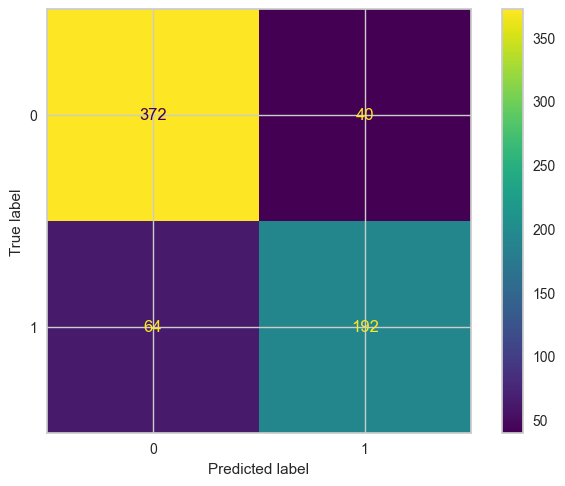

In [160]:
ConfusionMatrixDisplay.from_predictions(y_train, xgb_predict )
plt.show()

In [161]:
f1_xgboost = f1_score(y_train, xgb_predict)
f1_xgboost 

0.7868852459016394

# Stacking

In [24]:
from sklearn.ensemble import StackingClassifier

使用上面建好的隨機森林與xgboost模型來做stacking。

In [94]:
rf_final = full_pipeline_rf2.best_estimator_.named_steps["rf1"]
rf_final

RandomForestClassifier(max_depth=9, max_features=3, n_estimators=600,
                       random_state=42)

In [162]:
xgb_final

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=7000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [163]:
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_final),
        ('xgb', xgb_final)
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)

In [104]:
full_pipeline_stacking = Pipeline(
    [("preprocessing", preprocessing), ("stacking", stacking_clf)]
)

full_pipeline_stacking.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputeage',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex'])])),
                ('stacking',
                 StackingClassifier(cv=5,
                                    estimators=[('rf',
                                                 RandomForestClassifier(max_depth=9,
                                                                        max_features=3,
                                                                        n_estimators=600,...
                                                               interaction_constraints=None,
                                                               learning_rate=0.001,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=12,
                                                               max_leaves=None,
                                                               min_child_weight=1,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=7000,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...))],
                                    final_estimator=RandomForestClassifier(random_state=43)))])

In [105]:
full_pipeline_stacking_f1 = cross_val_score(full_pipeline_stacking, x_train, y_train, scoring="f1", cv = 3)
full_pipeline_stacking_f1

array([0.70731707, 0.69798658, 0.6746988 ])

In [99]:
stacking_predict = cross_val_predict(full_pipeline_stacking, x_train, y_train, cv=3)

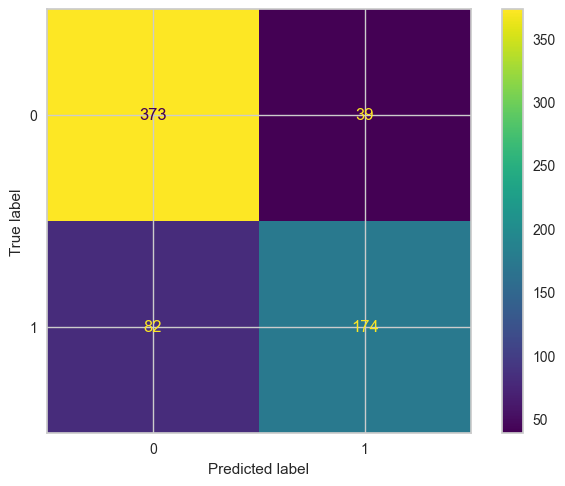

In [106]:
ConfusionMatrixDisplay.from_predictions(y_train, stacking_predict)
plt.show()

In [107]:
f1_stacking= f1_score(y_train, stacking_predict )
f1_stacking

0.742004264392324

發現結果差的多，原因可能是這樣並沒有達到學習器多樣化，可能用不同的弱學習器來做stacking效果會好得多

# Conclusion

In [142]:
f1_scores = {
    'Model': ['Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boost', 'XGBoost', 'Stacking'],
    'F1 Score': [f1_rf, f1_extratree, f1_adaboost, f1_gradientboost, f1_xgboost, f1_stacking]
}

# Create the data frame
df = pd.DataFrame(f1_scores)

# Print the data frame
print(df)

            Model  F1 Score
0   Random Forest  0.778226
1     Extra Trees  0.729958
2        AdaBoost  0.718367
3  Gradient Boost  0.792683
4         XGBoost  0.786885
5        Stacking  0.742004


# Evaluate Your System on the Test Set.

In [146]:
final_predictions_rf = full_pipeline_rf2.best_estimator_.predict(x_test)
final_f1_rf = f1_score(y_test, final_predictions_rf)
print(final_f1_rf)

0.7388535031847132


In [147]:
final_predictions_extra = full_pipeline_extra2.best_estimator_.predict(x_test)
final_f1_extra = f1_score(y_test, final_predictions_extra)
print(final_f1_extra)

0.7295597484276729


In [148]:
final_predictions_ada = full_pipeline_ada2.best_estimator_.predict(x_test)
final_f1_ada = f1_score(y_test, final_predictions_ada)
print(final_f1_ada)

0.6867469879518072


In [153]:
final_predictions_gbc = full_pipeline_final.predict(x_test)
final_f1_gbc = f1_score(y_test, final_predictions_gbc)
print(final_f1_gbc)

0.6891891891891893


In [164]:
final_predictions_xgb = full_pipeline_final_xgb.predict(x_test)
final_f1_xgb = f1_score(y_test, final_predictions_xgb)
print(final_f1_xgb)

0.7361963190184049


In [165]:
final_predictions_stacking = full_pipeline_stacking.predict(x_test)
final_f1_stacking= f1_score(y_test, final_predictions_stacking)
print(final_f1_stacking)

0.6832298136645963


In [166]:
test_f1_scores = {
    'Model': ['Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boost', 'XGBoost', 'Stacking'],
    'test set F1 Score': [final_f1_rf, final_f1_extra, final_f1_ada, final_f1_gbc, final_f1_xgb, final_f1_stacking]
}

# Create the data frame
df_test_f1 = pd.DataFrame(test_f1_scores)

# Print the data frame
print(df_test_f1)

            Model  test set F1 Score
0   Random Forest           0.738854
1     Extra Trees           0.729560
2        AdaBoost           0.686747
3  Gradient Boost           0.689189
4         XGBoost           0.736196
5        Stacking           0.683230


終究還是RF跟XGBoost表現最好